# Validation for National Intertidal Digital Elevation Model (NIDEM)

**What does this notebook do?** This notebook validates National Intertidal Digital Elevation Model (NIDEM) data against multiple validation datasets (RTK GPS, 5m LIDAR DEM data and multibeam). 

**Date:** April 2018

**Author:** Robbi Bishop-Taylor

## Load modules and define functions

In [1]:
# Import libraries
import sys
import os
import glob
import fiona
import itertools
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from shapely.geometry import Point
from pyproj import Proj, transform
from osgeo import gdal
from scipy import stats
from matplotlib import pyplot as plt
from IPython.display import display

# Import DEA Notebooks scripts
sys.path.append(os.path.abspath('/g/data/r78/rt1527/dea-notebooks/algorithms'))
import SpatialTools 

# Set working directory
os.chdir('/g/data/r78/rt1527/nidem')


def plot_kde(x, y, nbins=300, y_lims=(-5, 5), x_lims=(-5, 5), power=1.0):
    
    """
    Plots set of paired x and y values as a kernel density plot 
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor    
    
    :attr x: list of observed values (e.g. validation data or field observations)
    :attr y: list of modelled values
    :attr nbins: number of x/y axis bins used to compute kernel density (default: 300)
    :attr y_lims: y-axis limits for plot (default: (-5, 5))
    :attr x_lims: x-axis limits for plot (default: (-5, 5))
    :attr power: optionally allows you to stretch the resulting kernel density values by raising
                 by a power prior to plotting. Values below 1 visually enhance low density areas
    """

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    k = stats.kde.gaussian_kde([x, y])
    xi, yi = np.mgrid[y_lims[0]:y_lims[1]:nbins*1j, x_lims[0]:x_lims[1]:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    zi = np.power(zi, power)    

    # Plot output x-y scatter plot
    fig, ax = plt.subplots(figsize = (12, 12))
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = "magma")
    ax.set_ylim(y_lims[0], y_lims[1])
    ax.set_xlim(x_lims[0], x_lims[1])

    
def RMSE(x, y):
    
    """
    Computes root mean squared error (RMSE) from two lists of observed and modelled values. 
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor    
    
    :attr x: list of observed values (e.g. validation data or field observations)
    :attr y: list of modelled values
    
    :returns: float of computed RMSE 
    """
    
    return ((y - x) ** 2).mean() ** 0.5

## RTK GPS validation
Test the resulting DEM by comparing against RTK GPS field-recorded data. Because validation data only exists for polygon 33 (Darwin), this imports DEM data for polygon 33 if another polygon is being analysed.

In [76]:
# Import NIDEM polygon 33 from file
nidem_raster = "output_data/dem/NIDEM_dem_33.tif"
nidem_ds = gdal.Open(nidem_raster)
nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray() 

# Open validation point shapefile and use to extract data from underlying array
with fiona.open('raw_data/validation/EastPointonlyRTK_albers.shp') as points:

    point_output = list()

    for n, point in enumerate(points):

        # Extract data from shapefile points; fix units by multiplying by 1000
        x_coord, y_coord = point["geometry"]["coordinates"]
        gps_elev = point["properties"]["field_4"] 

        # Append to list
        point_output.append([x_coord, y_coord, gps_elev])

# Unzip point lists into lists of coords and elevation values
x_coords, y_coords, gps_elev = zip(*point_output) 

# Convert geographic coordinates into index coordinates
x_inds, y_inds =  SpatialTools.coords_to_indices(x_coords=x_coords, y_coords=y_coords,
                                                 input_raster=nidem_raster) 

# Extract NIDEM elevation data and combine into dataframe
nidem_elev = nidem_array[y_inds, x_inds] / 1000.0
gps_val_df = pd.DataFrame({"gps_elev": gps_elev, 
                           "nidem_elev": nidem_elev}).dropna()


## Lidar validation - correlations

In [95]:
# Dict of study areas and to process; contains matching ITEM polygon and MGA zone for each LIDAR dataset
study_areas_df = pd.read_csv('study_areas.csv', index_col=0)
study_areas = study_areas_df.to_dict('index')

out_list = list()

for key in study_areas: 
    
    print(key)
    
    # Use ITEM polygon and MGA zone from file
    polygon = study_areas[key]['item_polygon']
    mga_zone = study_areas[key]['mga_zone']
    lidar_raster = study_areas[key]['lidar_raster']
  
    # Import Intertidal DEM data
    nidem_raster = 'output_data/dem/NIDEM_dem_{}.tif'.format(polygon)
    nidem_ds = gdal.Open(nidem_raster)
    nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray() 
    nidem_prj = nidem_ds.GetProjection()
    nidem_geotrans = nidem_ds.GetGeoTransform()
    
    # Import data
    points_df = pd.read_csv('output_data/validation/output_points_{}.csv'.format(key))  
    
    ulx, lrx = np.percentile(points_df.point_lon, [0, 100])  
    lry, uly = np.percentile(points_df.point_lat, [0, 100]) 
    
    # Clip LIDAR raster to extent of points
    gdal.Translate(destName='scratch/lidar_clipped.tif', 
                   srcDS=lidar_raster, 
                   projWin=[ulx-0.01, uly+0.01, lrx+0.01, lry-0.01],
                   projWinSRS="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    
    # Reproject LIDAR raster to extent/cell size/projection of NIDEM layer
    lidar_reproj = SpatialTools.reproject_to_template(input_raster='scratch/lidar_clipped.tif',
                                                      template_raster=nidem_raster, 
                                                      output_raster='scratch/lidar_resampled.tif', 
                                                      resampling=gdal.GRA_Bilinear, nodata_val=0)   
    
    # Convert lat-lon points to X and Y Australian Albers coords
    x, y = transform(p1=Proj(init='EPSG:4326'), p2=Proj(init="EPSG:3577"),
                     x=points_df['point_lon'].values, y=points_df['point_lat'].values)

    # Convert Australian Albers points to NIDEM raster indices
    x_ind, y_ind = SpatialTools.coords_to_indices(x_coords=x, y_coords=y,
                                     input_raster="output_data/dem/NIDEM_dem_{}.tif".format(polygon))  
    
    # Create mask of areas with exposed non-water LIDAR points
    mask_unfiltered = np.full(nidem_array.shape, False) 
    mask_unfiltered[y_ind, x_ind] = True
    
    # Clean mask using morphological opening and closing
    mask = ndimage.binary_opening(mask_unfiltered)
    mask = ndimage.binary_closing(mask)
    
    # Extract LIDAR and NIDEM elevation data
    lidar_elev = lidar_reproj.GetRasterBand(1).ReadAsArray()[mask]   
    nidem_elev = nidem_array[mask] / 1000.0
    
    # Combine into dataframe
    test_df = pd.DataFrame({"lidar_elev": lidar_elev, "nidem_elev": nidem_elev}).dropna()
    out_list.append(test_df)
    print('    Comparing {} raster pixels'.format(len(test_df)))
    
    # Export mask to file
    SpatialTools.array_to_geotiff(fname = "scratch/lidar_mask_{}.tif".format(key), 
                                  data = mask, 
                                  geo_transform = nidem_geotrans, 
                                  projection = nidem_prj, 
                                  nodata_val = 0)    
    # Close datasets
    lidar_reproj = None
    nidem_ds = None
    
# Combine into single dataframe
lidar_val_df = pd.concat(out_list) 

# Take random sample
lidar_val_df = lidar_val_df.sample(20000)


Whitsunday
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/lidar_resampled.tif
    Comparing 13973 raster pixels
Gladstone
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/lidar_resampled.tif
    Comparing 12573 raster pixels
Rockhampton
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/lidar_resampled.tif
    Comparing 8197 raster pixels
Isaac
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/lidar_resampled.tif
    Comparing 33693 raster pixels
Mackay
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/lidar_resampled.tif
    Comparing 32610 raster pixels
Fraser
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/lidar_resampled.tif
    Comparing 13089 raster pixels
Kaurumba
Importing raster datasets
Reprojecting raster
Reprojected raster exported to scratch/lidar_resampled.tif


## Multibeam validation - correlations

In [97]:
# Paths to multibeam datasets
multibeam_paths = glob.glob("raw_data/validation/WAMSI_KimberlyReefs/*.tif")

# Merge NIDEM polygons with gdal_merge
os.system('gdal_merge.py -n 0 -a_nodata 0 -o ' \
          'scratch/nidem_merged.tif ' \
          'output_data/dem/NIDEM_dem_78.tif ' \
          'output_data/dem/NIDEM_dem_139.tif ' \
          'output_data/dem/NIDEM_dem_152.tif')

# Merge multibeam datasets with gdal_merge
os.system('gdal_merge.py -n -9999 -a_nodata -9999 -o ' \
          'scratch/multibeam_merged.tif {}'.format(' '.join(multibeam_paths)))

# Reproject merged multibeam raster into dims/extent/proj of merged NIDEM raster 
SpatialTools.reproject_to_template(input_raster='scratch/multibeam_merged.tif',
                                   template_raster='scratch/nidem_merged.tif',                           
                                   output_raster='scratch/multibeam_reproj.tif',
                                   resampling=gdal.GRA_Bilinear)

# Import merged multibeam array
multibeam_ds = gdal.Open('scratch/multibeam_reproj.tif')
multibeam_array = multibeam_ds.GetRasterBand(1).ReadAsArray()

# Import merged NIDEM array
nidem_ds = gdal.Open('scratch/nidem_merged.tif')
nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray()

# Extract elevation data
mask = (multibeam_array != 0.) & (nidem_array != 0.)
multibeam_elev = multibeam_array[mask] 
nidem_elev = nidem_array[mask] / 1000.0

# Combine into dataframe
multibeam_val_df = pd.DataFrame({'multibeam_elev': multibeam_elev, 
                                 'nidem_elev': nidem_elev}).dropna()


,Pearson correlation,Spearman correlation,RMSE
RTK GPS,0.833040,0.856721,0.620476
Coastal LIDAR,0.933426,0.932857,0.430264
Multibeam,0.320035,0.734835,4.376287


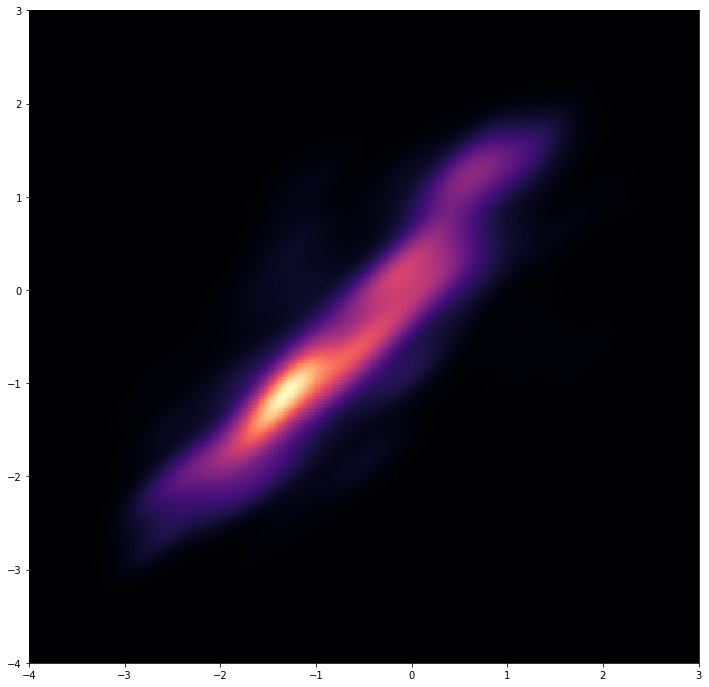

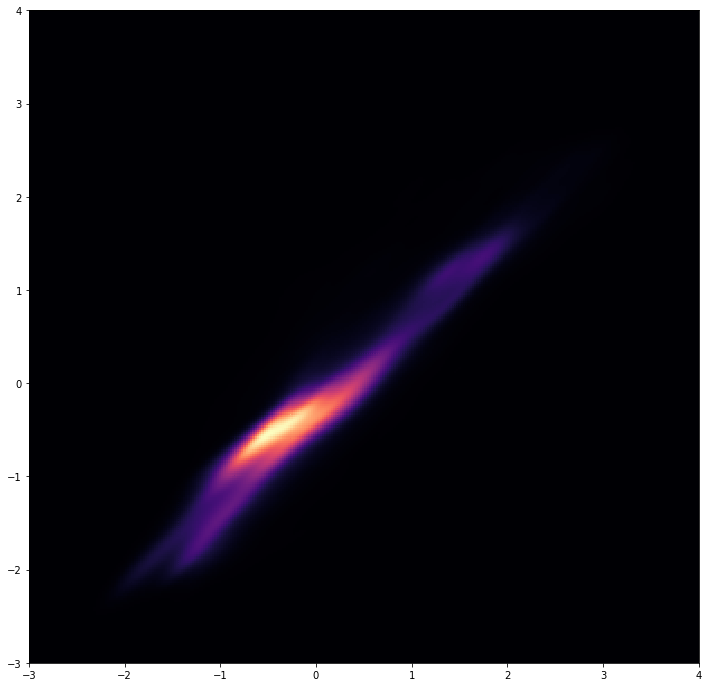

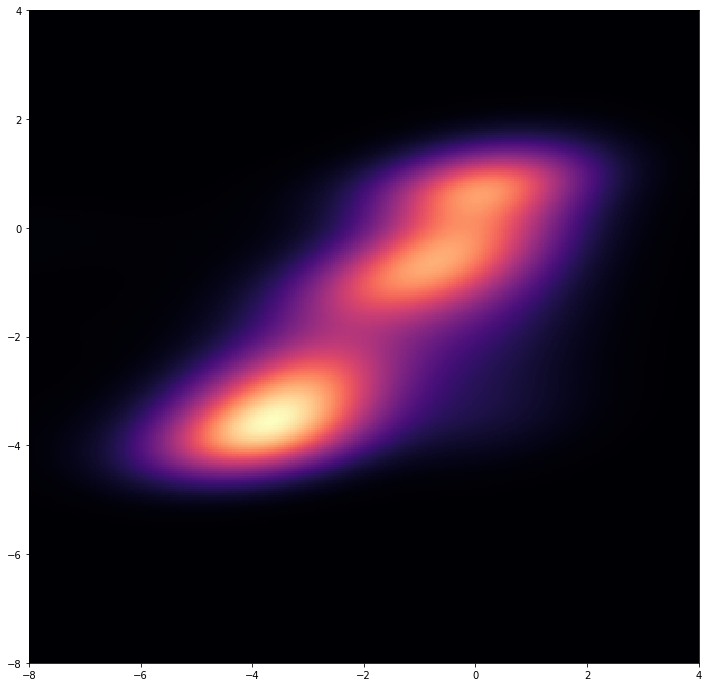

In [96]:
# Create dataframe of validation results 
val_df = pd.DataFrame({'Pearson correlation': [gps_val_df.corr(method='pearson').iloc[0, 1],
                                              lidar_val_df.corr(method='pearson').iloc[0, 1],
                                              multibeam_val_df.corr(method='pearson').iloc[0, 1]],

                       'Spearman correlation': [gps_val_df.corr(method='spearman').iloc[0, 1],
                                               lidar_val_df.corr(method='spearman').iloc[0, 1],
                                               multibeam_val_df.corr(method='spearman').iloc[0, 1]],

                       'RMSE': [RMSE(x=gps_val_df["gps_elev"], 
                                     y=gps_val_df["nidem_elev"]),
                                RMSE(x=lidar_val_df["lidar_elev"], 
                                     y=lidar_val_df["nidem_elev"]),
                                RMSE(x=multibeam_val_df["multibeam_elev"], 
                                     y=multibeam_val_df["nidem_elev"])]}, 
    
                       index=["RTK GPS", "Coastal LIDAR", "Multibeam"])

# Reorder columns
val_df = val_df[['Pearson correlation', 'Spearman correlation', 'RMSE']]
display(val_df)

# RTK-GPS kernel density plot
plot_kde(x_vals=gps_val_df.gps_elev, 
         y_vals=gps_val_df.nidem_elev, 
         x_lims=(-4, 3), y_lims=(-4, 3), power=1)  

# Coastal lidar kernel density plot
plot_kde(x_vals=lidar_val_df.lidar_elev, 
         y_vals=lidar_val_df.nidem_elev, 
         x_lims=(-3, 4), y_lims=(-3, 4), power=1.0) 

# Multibeam kernel density plot
plot_kde(x_vals=multibeam_val_df.multibeam_elev, 
         y_vals=multibeam_val_df.nidem_elev, 
         x_lims=(-8, 4), y_lims=(-8, 4), power=1.0)


## Export NIDEM elevations and ranges per polygon

In [25]:
out_list = list()

# For each NIDEM DEM, export .csv of min, max elevations and range
for dem in glob.glob("output_data/dem/*.tif"):
    
    # open raster and choose band to find min, max
    gtif = gdal.Open(dem)
    srcband = gtif.GetRasterBand(1)

    # Get raster statistics
    stats = srcband.GetStatistics(True, True)
    
    # Get attributes
    polygon = dem.split("_")[-1][:-4]
    elev_min = stats[0]
    elev_max = stats[1]
    elev_range = elev_max - elev_min
    
    # Append to list
    out_list.append([polygon, elev_min, elev_max, elev_range])    
    
    gtif = None

# Combine values into pandas dataframe and export to .csv
polygon_elev_df = pd.DataFrame(out_list, columns=['ID', 'elev_min', 'elev_max', 'elev_range'])
polygon_elev_df.to_csv("nidem_polygons.csv", index=False)
        